In [2]:
import numpy as np
from astropy.io import fits
from loguru import logger
from pathlib import Path

from surfh.Models import instru

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import ndimage

from sklearn.decomposition import NMF
from einops import rearrange
from surfh.Models import wavelength_mrs
from surfh.Simulation import simulation_data

(22,)


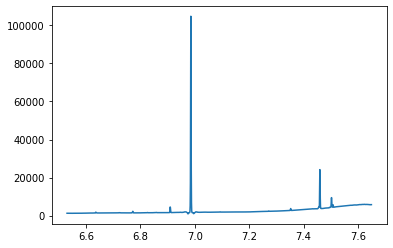

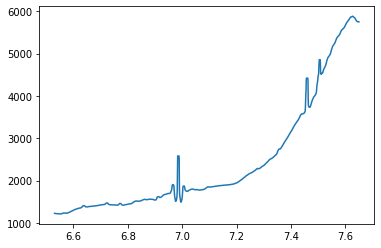

In [2]:
hdul = fits.open('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Raw_slices/ChannelCube_ch1-long_s3d.fits')
data_cube = hdul[1].data
raw_data_cube = hdul[1].data
data_cube = data_cube[:,5:-5,5:-5]
hdr = hdul[1].header
wavel = (np.arange(hdr['NAXIS3']) +hdr['CRPIX3'] - 1) * hdr['CDELT3'] + hdr['CRVAL3']

nan_idx = np.where(np.isnan(data_cube))
print(nan_idx[0].shape)
# replace Nan with 0
data_cube[np.isnan(data_cube)] = 0
fitlered_data_cube = ndimage.median_filter(data_cube.copy(), size=15, axes=[0])


data = rearrange(data_cube, 'L I J -> (I J) L') # from spectro data
fitlered_data = rearrange(fitlered_data_cube, 'L I J -> (I J) L') # from spectro data



plt.plot(wavel, np.mean(data_cube, axis=(1,2)))
plt.figure()
plt.plot(wavel, np.mean(fitlered_data_cube, axis=(1,2)))

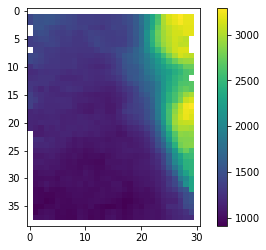

In [3]:
plt.imshow(hdul[1].data[100])
plt.colorbar()
plt.show()

/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number 

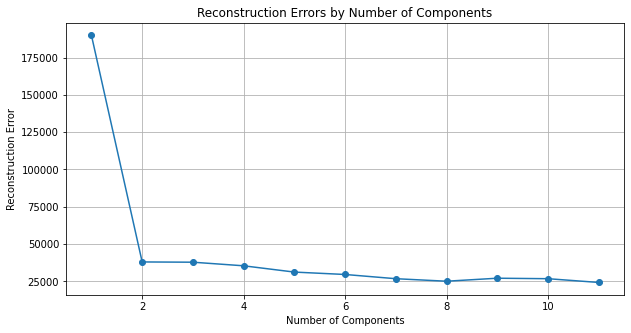

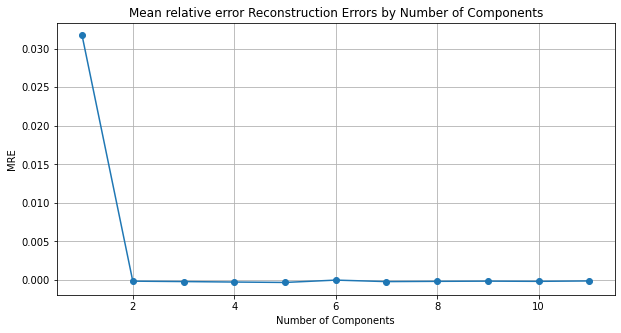

In [4]:
# Range of components to test
component_range = range(1, 12)  # Adjust based on how many tests you want to run

# List to store the reconstruction errors
reconstruction_errors = []
mre_reconstruction_errors = []

# Compute NMF for different numbers of components and calculate the reconstruction errors
for n_components in component_range:
    nmf = NMF(n_components=n_components, init='random', random_state=42)
    W = nmf.fit_transform(fitlered_data)  # W is the weight matrix
    H = nmf.components_          # H is the feature matrix (components)
    reconstructed = W @ H        # Reconstruct the original matrix
    error = np.linalg.norm(fitlered_data - reconstructed)  # Frobenius norm
    mre_error = np.mean(np.divide((fitlered_data-reconstructed), fitlered_data, out=np.zeros_like(fitlered_data), where=fitlered_data!=0))

    reconstruction_errors.append(error)
    mre_reconstruction_errors.append(mre_error)

# Plotting the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(component_range, reconstruction_errors, marker='o')
plt.title('Reconstruction Errors by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.grid(True)

# Plotting the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(component_range, mre_reconstruction_errors, marker='o')
plt.title('Mean relative error Reconstruction Errors by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MRE')
plt.grid(True)



In [5]:
from sklearn.decomposition import NMF

# Initialize NMF with the desired number of components
nmf = NMF(n_components=2, init='random', random_state=0, max_iter=1000)

# Fit NMF model to your data
nmf.fit(fitlered_data)

# Extract the components (eigenvectors)
components = nmf.components_

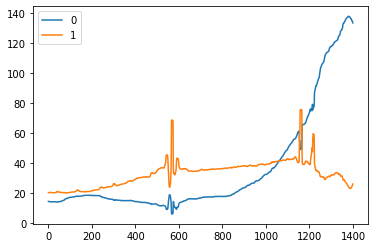

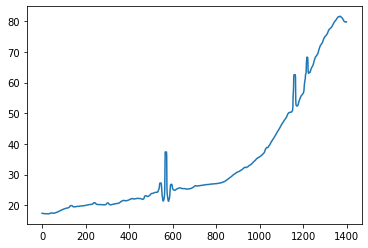

In [6]:
plt.figure()
for i in range(components.shape[0]):
    plt.plot(components[i], label=i)
plt.legend()
 
plt.figure()
plt.plot(np.mean(components, axis=0))

In [7]:
def reduce_vector_to_shape(vector, target_shape):
    """
    Reduce a vector by randomly removing elements to reach the specified target shape.\n",
    \n",
    Parameters:\n",
    vector (np.ndarray): The input vector to reduce.\n",
    target_shape (int): The target length of the vector.\n",
    \n",
    Returns:\n",
    np.ndarray: The reduced vector.\n",
    """
    original_shape = vector.shape[0]
 
    first_subsampled_factor = original_shape//target_shape
    tmp_vector = vector[::first_subsampled_factor]
    tmp_shape = tmp_vector.shape[0
                          ]
    # Ensure the target shape is smaller than the original shape\n",
    if target_shape >= original_shape:
        raise ValueError("Target shape must be smaller than the original vector length.")

    # Determine how many elements to remove\n",
    num_elements_to_remove = tmp_shape - target_shape
    # Randomly select indices to remove\n",
    indices_to_remove = np.random.choice(tmp_shape, num_elements_to_remove, replace=False)
    # Remove the selected elements\n",
    reduced_vector = np.delete(tmp_vector, indices_to_remove)
    return reduced_vector


sim_dir_path='/home/nmonnier/Projects/JWST/MRS/surfh/cube_orion/'
_, _, wavel_axis, _, _, _ = simulation_data.get_simulation_data(4, 0, sim_dir_path)

# Get indexes of the cube_wavelength for specific wavelength window
indexes = np.where((wavel_axis>wavelength_mrs.get_mrs_wavelength('1c')[0]) & (wavel_axis<wavelength_mrs.get_mrs_wavelength('1c')[-1]))[0]
window_slice = slice(indexes[0]-1, indexes[-1] +1, None) # 
# Update wavelength for simulated data
wavel_axis = wavel_axis[window_slice]

subsampled_components = np.zeros((components.shape[0], len(wavel_axis)))

for i in range(components.shape[0]):
    subsampled_components[i] = reduce_vector_to_shape(components[i], len(wavel_axis))


2


In [8]:
def downsample_interpolation(vector, target_size):
    x_old = np.linspace(0, 1, len(vector))
    x_new = np.linspace(0, 1, target_size)
    return np.interp(x_new, x_old, vector)

subsampled_interpn = np.zeros((components.shape[0], len(wavel_axis)))

for i in range(components.shape[0]):
    subsampled_interpn[i] = downsample_interpolation(components[i], len(wavel_axis))



In [12]:
def downsample_fft(vector, target_size):
    # Apply FFT and keep the lower frequencies
    fft_coeff = np.fft.rfft(vector)
    truncated_fft = np.zeros(target_size//2 + 1, dtype=complex)
    truncated_fft[:target_size//2 + 1] = fft_coeff[:target_size//2 + 1]
    # Inverse FFT to reconstruct the downsampled signal
    return np.fft.irfft(truncated_fft, target_size)

# Example usage
subsampled_fft = np.zeros((components.shape[0], len(wavel_axis)))

for i in range(components.shape[0]):
    subsampled_fft[i] = downsample_fft(components[i], len(wavel_axis))


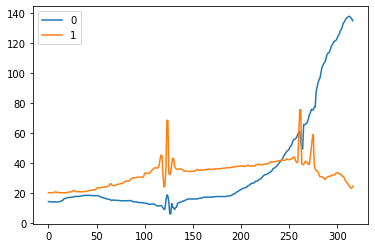

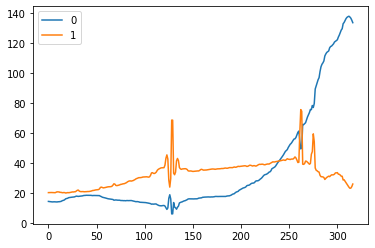

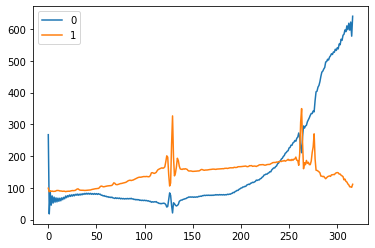

In [13]:
plt.figure()
for i in range(subsampled_components.shape[0]):
    plt.plot(subsampled_components[i], label=i)
plt.legend()
plt.figure()
for i in range(subsampled_components.shape[0]):
    plt.plot(subsampled_interpn[i], label=i)
plt.legend()
plt.figure()
for i in range(subsampled_components.shape[0]):
    plt.plot(subsampled_fft[i], label=i)
plt.legend()

In [37]:
np.save('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Templates/nmf_orion_1C_2_templates_1400samples.npy', components)

2


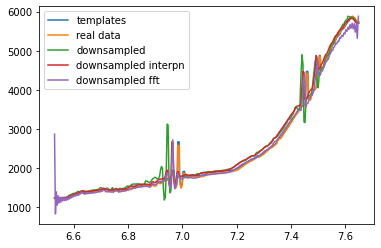

In [16]:

sim_dir_path='/home/nmonnier/Projects/JWST/MRS/surfh/cube_orion/'
_, _, wavel_axis, _, _, _ = simulation_data.get_simulation_data(4, 0, sim_dir_path)

# Get indexes of the cube_wavelength for specific wavelength window
indexes = np.where((wavel_axis>wavelength_mrs.get_mrs_wavelength('1c')[0]) & (wavel_axis<wavelength_mrs.get_mrs_wavelength('1c')[-1]))[0]
window_slice = slice(indexes[0]-1, indexes[-1] +1, None) # 
wavel_axis = wavel_axis[window_slice]

scale_f = np.max(np.mean(fitlered_data_cube, axis=(1,2)))/np.max(np.mean(subsampled_components, axis=0))
scale_fft = np.max(np.mean(fitlered_data_cube, axis=(1,2)))/np.max(np.mean(subsampled_fft, axis=0))

plt.plot(wavel, np.mean(components, axis=0)*scale_f, label='templates')
plt.plot(wavel, np.mean(fitlered_data_cube, axis=(1,2)), label='real data')
plt.plot(wavel_axis, np.mean(subsampled_components, axis=0)*scale_f, label='downsampled')

plt.plot(wavel_axis, np.mean(subsampled_interpn, axis=0)*scale_f, label='downsampled interpn')
plt.plot(wavel_axis, np.mean(subsampled_fft, axis=0)*scale_fft, label='downsampled fft')

plt.legend()

## On travail maintenant sur un cube contenant les info des channels 1 et 2

In [3]:
hdul = fits.open('/home/nmonnier/Data/JWST/Orion_bar/Fusion/ChannelCube_ch1-2-shortmediumlong_s3d.fits')
data_cube = hdul[1].data
raw_data_cube = hdul[1].data
hdr = hdul[1].header
wavel = (np.arange(hdr['NAXIS3']) +hdr['CRPIX3'] - 1) * hdr['CDELT3'] + hdr['CRVAL3']

nan_idx = np.where(np.isnan(data_cube))
print(nan_idx[0].shape)
# replace Nan with 0
data_cube[np.isnan(data_cube)] = 0
fitlered_data_cube = ndimage.median_filter(data_cube.copy(), size=15, axes=[0])


data = rearrange(data_cube, 'L I J -> (I J) L') # from spectro data
fitlered_data = rearrange(fitlered_data_cube, 'L I J -> (I J) L') # from spectro data



plt.plot(wavel, np.mean(data_cube, axis=(1,2)))
plt.figure()
plt.plot(wavel, np.mean(fitlered_data_cube, axis=(1,2)))

FileNotFoundError: [Errno 2] No such file or directory: '/home/nmonnier/Data/JWST/Orion_bar/Fusion/Raw_slices/ChannelCube_ch1-2-shortmediumlong_s3d.fits'